# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn import svm

# Base DataFrame & collision scaling

In [2]:
df = pd.read_csv('../raw_data/clean.csv').drop(columns = ['primary_road','weather_1','latitude','longitude','week_of_the_year','case_id'])
df['routes'] = df['routes'].apply(lambda x : x.upper())
df


,collision_severity,hour,day_of_the_week,routes
0,1,10,4,VENTURA FREEWAY
1,1,6,3,SAN DIEGO FREEWAY
2,3,6,3,VENTURA FREEWAY
3,2,6,3,VENTURA FREEWAY
4,1,14,3,RONALD REAGAN FREEWAY
...,...,...,...,...
718658,2,1,3,FOOTHILL FREEWAY
718659,2,16,0,HINDRY AVENUE
718660,5,1,6,CHAPMAN AVENUE
718661,1,4,0,POMONA FREEWAY


In [3]:
df['routes'].value_counts().tail(20000)

HORSETHIEF CANYON ROAD        28
KELLA AVENUE                  28
SOUTH SPRING STREET           28
NORTH VALLEY CENTER AVENUE    28
MARIGOLD AVENUE               28
                              ..
SLAUGHTER ROAD                 1
NORTH DEERPARK DRIVE           1
SHERBORN STREET                1
GOLDEN PRADOS DRIVE            1
NORTH FERN STREET              1
Name: routes, Length: 20000, dtype: int64

### Scaling compris entre 1 et 100

In [4]:
def scaling(x):
    return round(2.5195**x - 1.5195)
    
df.collision_severity = df.collision_severity.apply(scaling)
df.head()

,collision_severity,hour,day_of_the_week,routes
0,1,10,4,VENTURA FREEWAY
1,1,6,3,SAN DIEGO FREEWAY
2,14,6,3,VENTURA FREEWAY
3,5,6,3,VENTURA FREEWAY
4,1,14,3,RONALD REAGAN FREEWAY


100


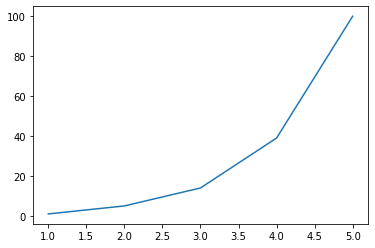

In [5]:
listi = np.arange(1,6,1)
scaled = []
for i in listi:
    scaled.append(scaling(i))
print(int(2.5195**5 - 1.5195))
plt.plot(listi,scaled);

# Define local variables for day and hour (for test fuctions below)

In [6]:
day = 2
hour = 13

# Dispatch roads of a trip into three lists, according to the scenario

#### scenario 1 : (road,hour,day) is in [existing_combinations]
#### scenario 2 : road not in [roads]
#### scenario 3 : if road in [roads], but no data for (hour,day)

In [7]:
def dispatch_roads(dictionary,dataframe,day,hour):
    """
    From a trip dictionary with roads as keys and distances as values,
    dispatches the roads into 3 lists according to the scenario
    """
    list_road_day_hour = []
    list_no_road = []
    list_no_day_hour = []
    
    for key,value in dictionary.items():
        
        if key.upper() not in dataframe['routes'].unique():
            list_no_road.append(key.upper())
            
        elif len(dataframe[(dataframe['routes'] == key.upper()) \
                           & (dataframe['day_of_the_week'] == day) & (dataframe['hour'] == hour)]) == 0:
            list_no_day_hour.append(key.upper())
            
        else:
            list_road_day_hour.append(key.upper())

    return list_road_day_hour, list_no_road, list_no_day_hour

In [8]:
dict_test = {'Ventura Freeway':200,'Ronald Reagan Freeway':500,'Boulevard richard LENOIR':450,\
             'Hindry Avenue':1300,'Dunnet Avenue':20,'Chapman Avenue':180,'Rue de la santé':370,'':300,\
             'ROSEMEAD BOULEVARD':427, 'ATLANTIC BOULEVARD':790,'GRAND AVENUE':457,'MARIGOLD AVENUE':1032,\
             'MILDRED STREET':123
            }

list_road_day_hour, list_no_road, list_no_day_hour = dispatch_roads(dict_test,df,day,hour)
print(f'list_road_day_hour = {list_road_day_hour}')
print(f'list_no_road = {list_no_road}')
print(f'list_no_day_hour = {list_no_day_hour}')

list_road_day_hour = ['VENTURA FREEWAY', 'RONALD REAGAN FREEWAY', 'HINDRY AVENUE', 'CHAPMAN AVENUE', 'ROSEMEAD BOULEVARD', 'ATLANTIC BOULEVARD', 'GRAND AVENUE']
list_no_road = ['BOULEVARD RICHARD LENOIR', 'RUE DE LA SANTÉ', '']
list_no_day_hour = ['DUNNET AVENUE', 'MARIGOLD AVENUE', 'MILDRED STREET']


# if (road,day,hour) is in [existing_combinations]:

#### i.e. si on a de la data pour ce tuple en question

In [9]:
def road_day_hour(dataframe,list_roads,day,hour):
    """
    For tuples of (roads,day,hour) we have data on,
    returns a dictionnary with roads as keys 
    and collision severity estimates as values
    """
    dict_predict = {}
    
    for road in list_roads:
        inter = dataframe[(dataframe['routes'] == road) \
                                    & (dataframe['day_of_the_week'] == day) \
                                    & (dataframe['hour'] == hour)]
        result = inter['collision_severity'].mean()
        dict_predict[road] = result
        
    return dict_predict

In [10]:
dict_1 = road_day_hour(df,list_road_day_hour,day,hour)
dict_1

{'VENTURA FREEWAY': 2.987012987012987,
 'RONALD REAGAN FREEWAY': 4.931034482758621,
 'HINDRY AVENUE': 3.0,
 'CHAPMAN AVENUE': 1.0,
 'ROSEMEAD BOULEVARD': 13.928571428571429,
 'ATLANTIC BOULEVARD': 2.7142857142857144,
 'GRAND AVENUE': 3.5}

In [11]:
df[(df['routes'] == 'CHAPMAN AVENUE') & (df['day_of_the_week'] == 2) & (df['hour'] == 13)]

,collision_severity,hour,day_of_the_week,routes
512173,1,13,2,CHAPMAN AVENUE


# if road not in [roads]

#### i.e. si la route renvoyée par l'API est inconnue

In [12]:
def road_not_in_roads(dataframe,list_roads,day,hour):
    """
    For roads don't have,
    returns a dictionnary with roads as keys 
    and collision severity estimates as values
    """
    dict_predict = {}
    
    inter = dataframe[(dataframe['day_of_the_week'] == day) \
                      & (dataframe['hour'] == hour)]
    result = inter['collision_severity'].mean()
    
    for road in list_roads:
        dict_predict[road] = result
        
    return dict_predict

In [13]:
dict_2 = road_not_in_roads(df,list_no_road,day,hour)
dict_2

{'BOULEVARD RICHARD LENOIR': 3.8152610441767068,
 'RUE DE LA SANTÉ': 3.8152610441767068,
 '': 3.8152610441767068}

# if road in [roads]

#### i.e. si on a la route, mais pas de donnée pour le tuple (heure,jour)

In [14]:
def no_day_hour(dataframe,list_roads,day,hour):
    """
    For roads we have, for which we don't have data on that date/hour,
    returns a dictionnary with roads as keys 
    and collision severity estimates as values
    """
    inter = df[df['routes'].isin(list_roads)].copy()

    X = inter.drop(columns = ['collision_severity'])
    y = inter['collision_severity']

    preprocessor = ColumnTransformer([('road_transformer', OneHotEncoder(sparse = False), ['routes'])])
    
    forest = RandomForestRegressor(n_estimators=100, n_jobs = -1)
    
    final_pipe = Pipeline([
        ('preprocessing', preprocessor),
        ('linear_regression', forest)])

    final_pipe_trained = final_pipe.fit(X,y)

    dict_predict = {}

    for road in list_roads: 
        X_pred = pd.DataFrame([[hour,day,road]], columns=['hour','day_of_the_week','routes'])
        result = final_pipe_trained.predict(X_pred)
        dict_predict[road] = result[0]

    return dict_predict

In [15]:
dict_3 = no_day_hour(df,list_no_day_hour,day,hour)
dict_3

{'DUNNET AVENUE': 2.1000168593363155,
 'MARIGOLD AVENUE': 3.4276345269532174,
 'MILDRED STREET': 4.740185003503834}

# Concat 3 dictionaries

In [16]:
def concat_3_dict(d1,d2,d3):
    """
    Concatenates 3 dictionaries
    """
    d4 = d1.copy()
    d4.update(d2)
    d4.update(d3)
    return d4

In [17]:
dict_concat = concat_3_dict(dict_1,dict_2,dict_3)
dict_concat

{'VENTURA FREEWAY': 2.987012987012987,
 'RONALD REAGAN FREEWAY': 4.931034482758621,
 'HINDRY AVENUE': 3.0,
 'CHAPMAN AVENUE': 1.0,
 'ROSEMEAD BOULEVARD': 13.928571428571429,
 'ATLANTIC BOULEVARD': 2.7142857142857144,
 'GRAND AVENUE': 3.5,
 'BOULEVARD RICHARD LENOIR': 3.8152610441767068,
 'RUE DE LA SANTÉ': 3.8152610441767068,
 '': 3.8152610441767068,
 'DUNNET AVENUE': 2.1000168593363155,
 'MARIGOLD AVENUE': 3.4276345269532174,
 'MILDRED STREET': 4.740185003503834}

# Compute ponderated mean

#### i.e. mean collision_severity ponderated by distance 

In [18]:
def ponderated_mean(d1,d2):
    """
    Takes two dictionaries in argument :
    the first one has roads in keys and distance in values,
    the second one has roads in keys and collision_severity in values.
    Computes the mean of collision_severities ponderated with distances
    """
    mean_danger = 0
    sum_dist = 0
    
    for key,value in d1.items():
        mean_danger += d2[key.upper()] * value
        sum_dist += value
        
    mean_danger = mean_danger/sum_dist
    
    return mean_danger

In [19]:
print(f'Dict of the trip : {dict_test}')
print(' ')
print(f'Dict of the collision severities : {dict_concat}')

Dict of the trip : {'Ventura Freeway': 200, 'Ronald Reagan Freeway': 500, 'Boulevard richard LENOIR': 450, 'Hindry Avenue': 1300, 'Dunnet Avenue': 20, 'Chapman Avenue': 180, 'Rue de la santé': 370, '': 300, 'ROSEMEAD BOULEVARD': 427, 'ATLANTIC BOULEVARD': 790, 'GRAND AVENUE': 457, 'MARIGOLD AVENUE': 1032, 'MILDRED STREET': 123}
 
Dict of the collision severities : {'VENTURA FREEWAY': 2.987012987012987, 'RONALD REAGAN FREEWAY': 4.931034482758621, 'HINDRY AVENUE': 3.0, 'CHAPMAN AVENUE': 1.0, 'ROSEMEAD BOULEVARD': 13.928571428571429, 'ATLANTIC BOULEVARD': 2.7142857142857144, 'GRAND AVENUE': 3.5, 'BOULEVARD RICHARD LENOIR': 3.8152610441767068, 'RUE DE LA SANTÉ': 3.8152610441767068, '': 3.8152610441767068, 'DUNNET AVENUE': 2.1000168593363155, 'MARIGOLD AVENUE': 3.4276345269532174, 'MILDRED STREET': 4.740185003503834}


Be careful, the roads will not be in the same order in each dictionary. One way to get the collision severities in the same order as the trip could be to update the values of the first dictionary with the values of the second dictionary. That way, the order is the same

In [20]:
result_de_la_mort_qui_tue = ponderated_mean(dict_test,dict_concat)
result_de_la_mort_qui_tue

4.109556000484461

# Test cross_val sur RandomForest()

In [21]:
list_no_day_hour = ['MARIGOLD AVENUE', 'MILDRED STREET']

In [22]:
inter = df[df['routes'].isin(list_road_day_hour)].copy()

X = inter.drop(columns = ['collision_severity'])
y = inter['collision_severity']

preprocessor = ColumnTransformer([('road_transformer', OneHotEncoder(sparse = False), ['routes'])])
    
forest = RandomForestRegressor(n_estimators=100, n_jobs = -1)

final_pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('linear_regression', forest)])
  
final_pipe_trained = final_pipe.fit(X,y)

cv_results = cross_val_score(final_pipe, X, y, cv=10, scoring = "r2")
    
cv_results



array([ 0.00084219,  0.00336273,  0.00688044, -0.00785981,  0.0090829 ,
        0.00876739,  0.00929702,  0.00433623,  0.01276124,  0.00580069])